<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>General parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Midpoint-normalizer" data-toc-modified-id="Midpoint-normalizer-0.2.0.1"><span class="toc-item-num">0.2.0.1&nbsp;&nbsp;</span>Midpoint normalizer</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#A-little-exploration" data-toc-modified-id="A-little-exploration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A little exploration</a></span><ul class="toc-item"><li><span><a href="#Artificial" data-toc-modified-id="Artificial-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Artificial</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="#Disambiguation" data-toc-modified-id="Disambiguation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Disambiguation</a></span><ul class="toc-item"><li><span><a href="#Artificial" data-toc-modified-id="Artificial-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Artificial</a></span></li><li><span><a href="#Pre-synaptic-rule" data-toc-modified-id="Pre-synaptic-rule-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pre-synaptic rule</a></span></li><li><span><a href="#Post-synaptic-rule" data-toc-modified-id="Post-synaptic-rule-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Post-synaptic rule</a></span></li></ul></li></ul></div>

Thoughts about so far in why this does not work.

Consider the post-synaptic case.
1  2  3     6   7  8
         5 
10 11 12    13  14  15

In the post-synaptic case, the problem is that five is activated sometimes when 3 is not and 5 is activated sometimes when 12 is not (in the pre-synaptic case the problem is that five sometimes is activated when 6 or 13 are not). 

If we consider the problem of creating a stable connection between 3 and 5 this is what happens.
When 3 and 5 are activated consecutively you have the the influence of the hebbian terms z_pre * z_post, but at the same time you have some anti-hebbian influence at the same time which makes the connection not so strong. Then, when 12 and 5 are activated, the connection between 3 and 5 gets the influence from the anti-hebbian terms which makes it weaker.

This is the crux, if we make the hebbian term stronger so the effect of the hebbian learning beats the anti-hebbian effects in 3-5 and 12-5 then we make the connections the self-connections so strong than the inhibition is not able to suppress the pattern after. 

# Preamble

In [1]:
import sys
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable


from network import run_network_recall, train_network, run_network_recall_limit
from connectivity import designed_matrix_sequences, designed_matrix_sequences_local
from analysis import get_recall_duration_for_pattern, get_recall_duration_sequence, create_sequence_chain
from analysis import time_t1, time_t2, time_t1_local, time_t2_local, time_t2_complicated

## General parameters

In [2]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)


plt.rcParams["figure.figsize"] = [16,9]
sns.set(font_scale=3.0)
sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})

lw = 8
ms = 18
alpha_graph = 0.3
color_palette = sns.color_palette()

In [3]:
dt = 0.001

## Functions

#### Midpoint normalizer

In [4]:
class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


norm = MidpointNormalize(midpoint=0)
cmap_show = matplotlib.cm.RdBu_r

# A little exploration

## Artificial

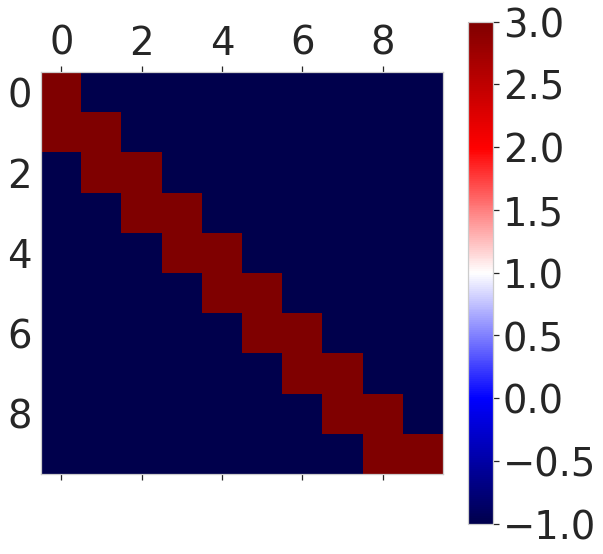

In [5]:
N = 10

tau_m = 0.010
tau_z = 0.100

G = 100.0
threshold = 0.5

self_excitation = 3.0
inhibition = 1
transition = 3.0

sequences = [[i for i in range(N)]]
w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)

plt.matshow(w, cmap='seismic')
plt.colorbar();

In [6]:
index_from = 2
index_to = 3
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

exc_t 3.0 exc_s 3.0 inh -1.0


0.04700036292457357
0.0
0.04700036292457357


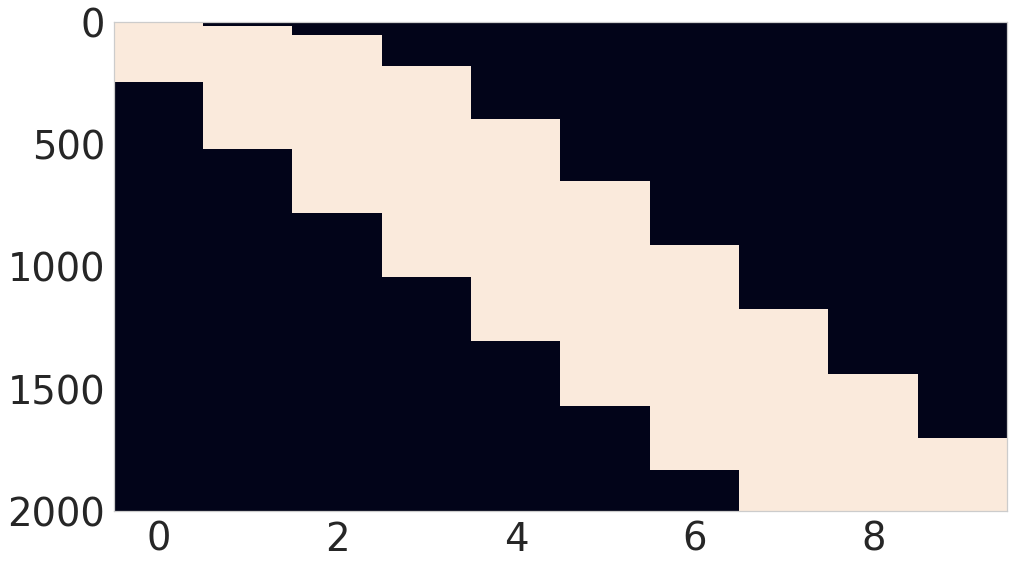

In [7]:
I_cue = 0
I_end = 5.0
T_cue = 3 * tau_m
t1 = time_t1(I=inhibition, T=transition, tau_z=tau_z, threshold=threshold)
t2 = time_t2(tau_z, A=self_excitation, T=transition, I=inhibition, threshold=threshold)
T_per = t1 + t2
print(t1)
print(t2)
print(T_per)
T = T_per * len(sequences[0]) + T_cue
T = 2.0

dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)

x_history = np.copy(dic['x'])
z_history = dic['z']
plt.imshow(x_history, aspect='auto');

In [8]:
pattern = 2
duration = get_recall_duration_for_pattern(x_history, pattern, dt)
print(duration)
print(t1 + t2)

0.726
0.04700036292457357


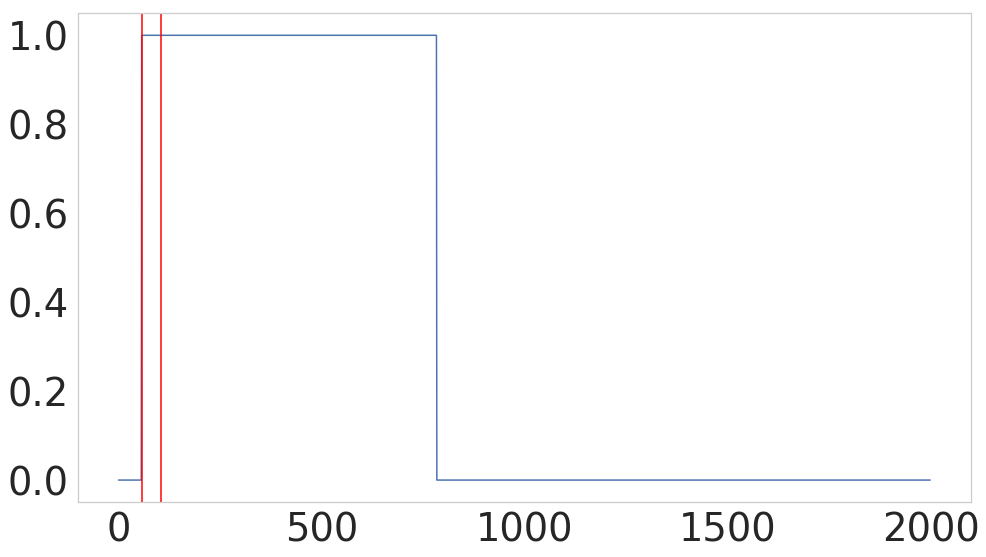

In [9]:
start = np.where(x_history[:, 2] > 0)[0][0] 
length = int(T_per / dt)
plt.plot(x_history[:, 2])
plt.axvline(start, color='red')
plt.axvline(start + length, color='red');

In [10]:
get_recall_duration_sequence(x_history, dt)

(0.8425,
 0.1548805991723947,
 [0.25,
  0.5,
  0.726,
  0.863,
  0.9089999999999999,
  0.9159999999999999,
  0.9159999999999999,
  0.8220000000000001,
  0.56,
  0.29800000000000004])

## Training

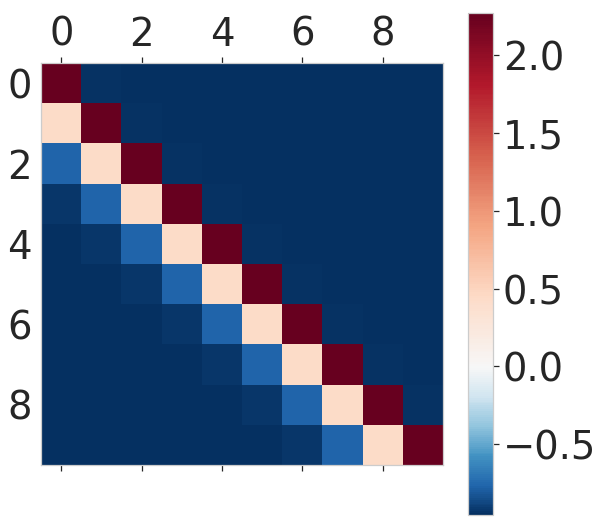

In [11]:
N = 10
sequences = [[0, 1, 2, 3, 4], [5, 6, 2, 8, 9]]
#sequences = [[5, 6, 2, 8, 9], [0, 1, 2, 3, 4]]
#sequences = [[0, 1, 2, 3, 4], [5, 6, 2, 8, 9], [5, 6, 2, 8, 9], [5, 6, 2, 8, 9], [0, 1, 2, 3, 4]]
sequences =[[i for i in range(N)]]

training_time = 0.100
inter_sequence_time = 1.0

max_w = 20.0
min_w = -10.0
gh = 2.0
gah = 1.0


threshold = 0.1
tau_z = 0.050
tau_z_post = 0.005
tau_w = 1.0
epochs = 1

dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, gh=gh, gah=gah, 
                    pre_rule=True, save_w_history=True)
w = dic['w']


plt.matshow(w, cmap=cmap_show, norm=norm)
plt.colorbar();

In [12]:
index_from = 2
index_to = 3
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

exc_t 0.43111444234401697 exc_s 2.2728059322877177 inh -0.938510897105852


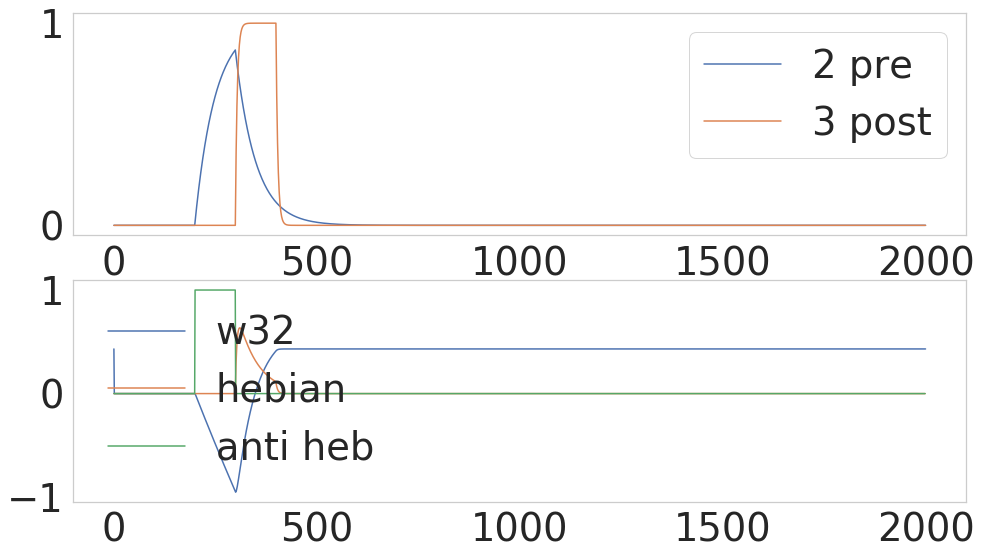

In [13]:
#time = np.arange(0, T, dt)
z = dic['z']
z_post = dic['z_post']
w_hist = dic['w_history']
normal = dic['normal']
negative = dic['negative']

fig = plt.figure()
ax = fig.add_subplot(211)

ax.plot(z[:, 2], label='2 pre')
ax.plot(z_post[:, 3], label='3 post')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(w_hist[:, 3, 2], label='w32')
ax.plot(normal[:, 3, 2], label='hebian')
ax.plot(negative[:, 3, 2], label='anti heb')
ax.legend(frameon=False);

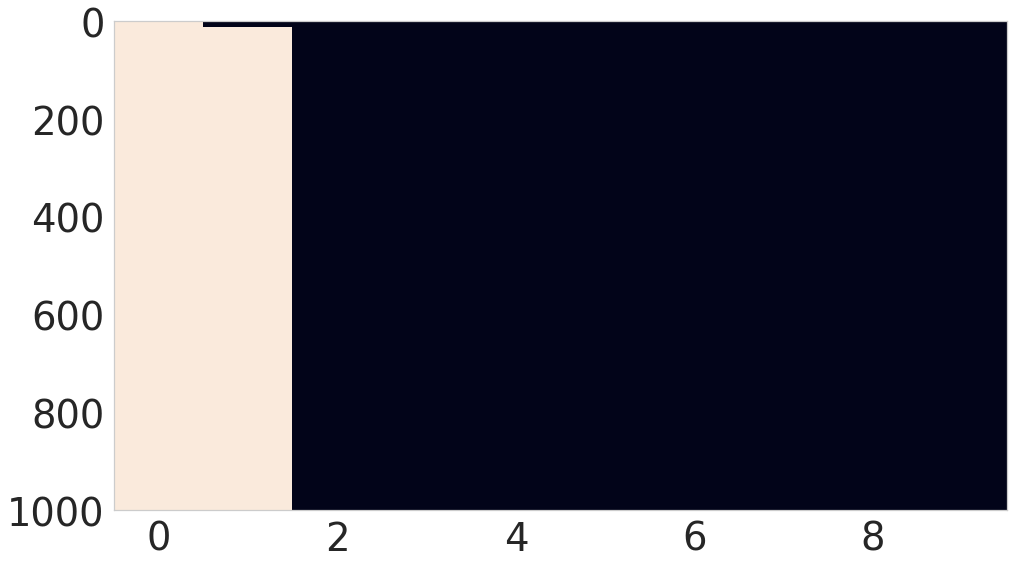

In [14]:
T = 1.0
I_end = 5.0
T_cue = 0.100

I_cue = sequences[0][0]
dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)
x_history = np.copy(dic['x'])
z_history = np.copy(dic['z'])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(x_history, aspect='auto')

# Disambiguation

## Artificial

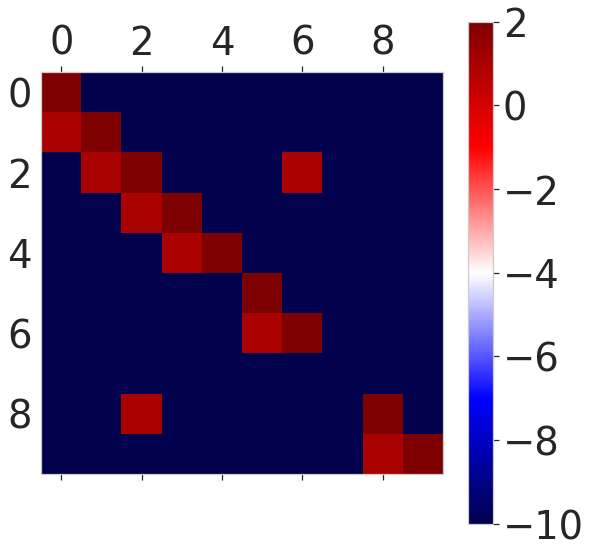

In [15]:
N = 10
sequences = [[0, 1, 2, 3, 4], [5, 6, 2, 8, 9]]
sequences = [[5, 6, 2, 8, 9], [0, 1, 2, 3, 4]]
#sequences = [[0, 1, 2, 3, 4], [5, 6, 2, 8, 9], [5, 6, 2, 8, 9], [5, 6, 2, 8, 9], [0, 1, 2, 3, 4]]

N = 10

tau_m = 0.010
tau_z = 0.250

G = 100.0
threshold = 0.5

self_excitation = 2.0
inhibition = 10.0
transition = 1.0

w = designed_matrix_sequences(N, sequences, self_excitation=self_excitation, 
                              transition=transition, inhibition=inhibition)

plt.matshow(w, cmap='seismic')
plt.colorbar();

In [16]:
index_from = 2
index_to = 8
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

index_from = 2
index_to = 3
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

exc_t 1.0 exc_s 2.0 inh -10.0
exc_t 1.0 exc_s 2.0 inh -10.0


In [17]:
t1 = time_t1(I=inhibition, T=transition, tau_z=tau_z, threshold=threshold)
t2 = time_t2(tau_z, A=self_excitation, T=transition, I=inhibition, threshold=threshold)
T_per = t1 + t2
print(t1)
print(t2)
print(T_per)
T = T_per * len(sequences[0]) + T_cue
I_end = 5.0
T_cue = 0.100

0.772760613339579
0.02660736571168284
0.7993679790512619


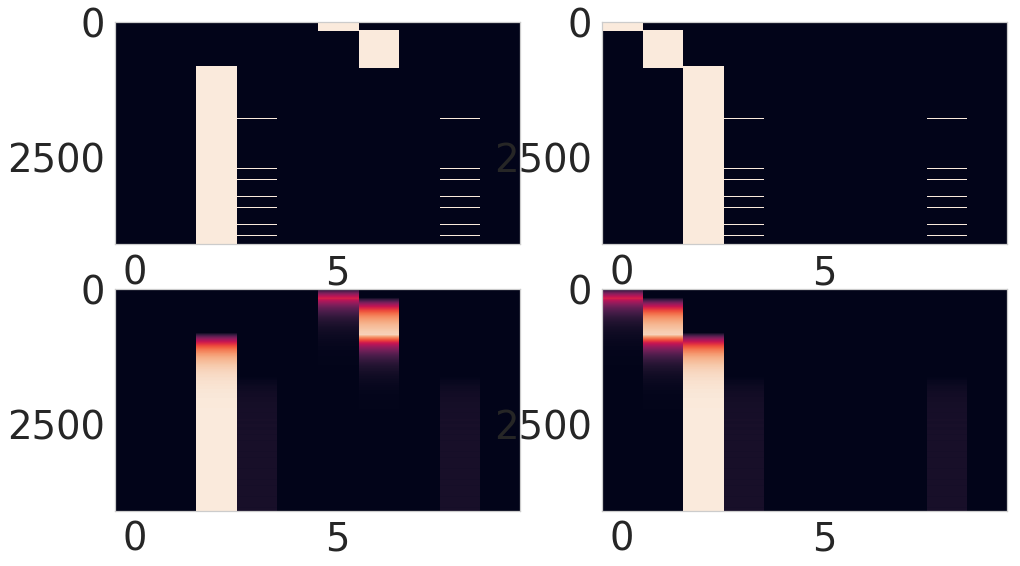

In [18]:
I_cue = sequences[0][0]
dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)
x_history_1 = np.copy(dic['x'])
z_history_1 = np.copy(dic['z'])

I_cue = sequences[1][0]
dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)
x_history_2 = np.copy(dic['x'])
z_history_2 = np.copy(dic['z'])

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(x_history_1, aspect='auto')

ax2 = fig.add_subplot(222)
ax2.imshow(x_history_2, aspect='auto')

ax3 = fig.add_subplot(223)
ax3.imshow(z_history_1, aspect='auto')

ax4 = fig.add_subplot(224)
ax4.imshow(z_history_2, aspect='auto');

In [19]:
I_cue

0

## Pre-synaptic rule

In [20]:
N = 10
sequences = [[0, 1, 2, 3, 4], [5, 6, 2, 8, 9]]
#sequences = [[5, 6, 2, 8, 9], [0, 1, 2, 3, 4]]
#sequences = [[0, 1, 2, 3, 4], [5, 6, 2, 8, 9], [5, 6, 2, 8, 9], [5, 6, 2, 8, 9], [0, 1, 2, 3, 4]]

training_time = 0.100
inter_sequence_time = 1.0

max_w = 20.0
min_w = -10.0
gh = 10.0
gah = 3.0


threshold = 0.5
tau_z = 0.050
tau_z_post = 0.005
tau_w = 1.0
epochs = 1

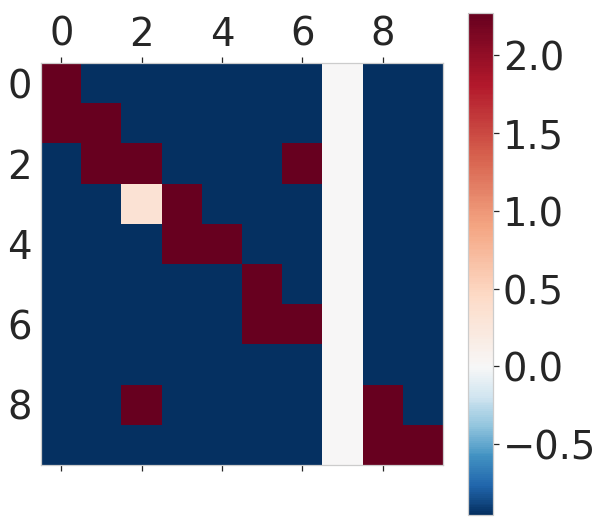

In [21]:
dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, gh=gh, gah=gah,
                    pre_rule=True, save_w_history=True)
w = dic['w']


plt.matshow(w, cmap=cmap_show, norm=norm)
plt.colorbar();

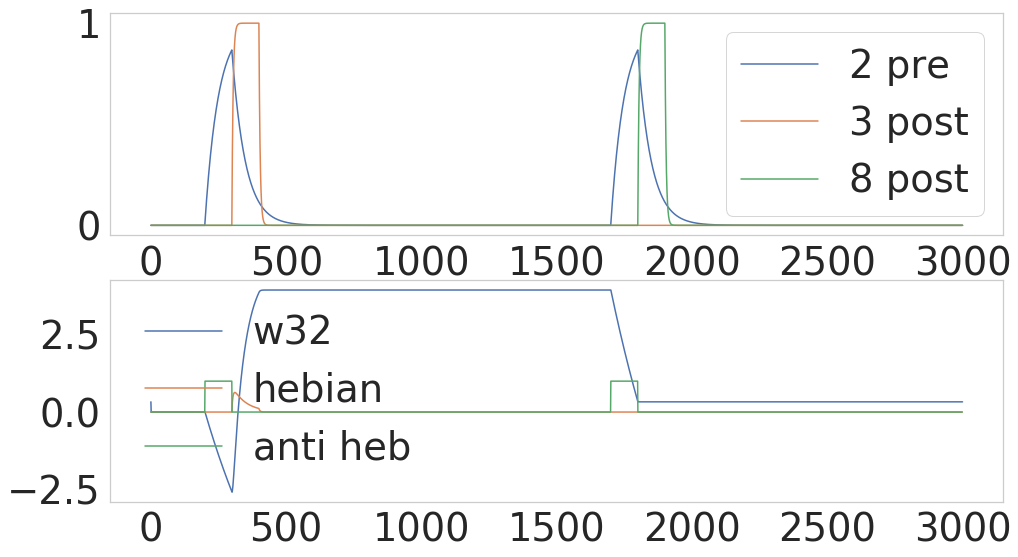

In [22]:
time = np.arange(0, T, dt)
z = dic['z']
z_post = dic['z_post']
w_hist = dic['w_history']
normal = dic['normal']
negative = dic['negative']

fig = plt.figure()
ax = fig.add_subplot(211)

ax.plot(z[:, 2], label='2 pre')
ax.plot(z_post[:, 3], label='3 post')
ax.plot(z_post[:, 8], label='8 post')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(w_hist[:, 3, 2], label='w32')
ax.plot(normal[:, 3, 2], label='hebian')
ax.plot(negative[:, 3, 2], label='anti heb')
ax.legend(frameon=False);

In [23]:
index_from = 2
index_to = 8
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

index_from = 2
index_to = 3
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

exc_t 2.5854461706340857 exc_s 14.033286408226068 inh -2.5383119497884024
exc_t 0.33007395590272626 exc_s 14.033286408226068 inh -2.538311949758203


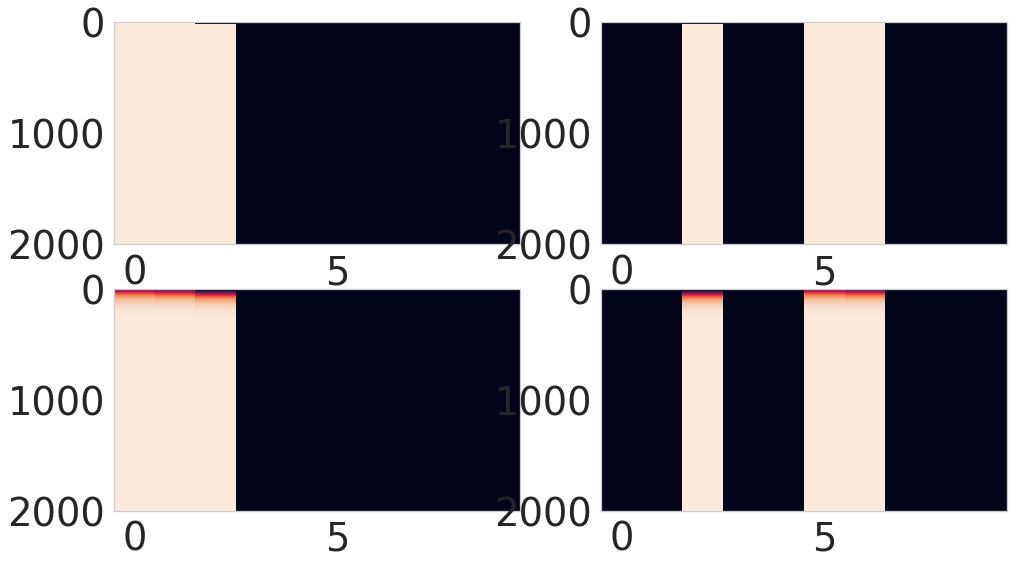

In [24]:
T = 2.0
I_end = 5.0
T_cue = 0.100

I_cue = sequences[0][0]
dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)
x_history_1 = np.copy(dic['x'])
z_history_1 = np.copy(dic['z'])

I_cue = sequences[1][0]
dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)
x_history_2 = np.copy(dic['x'])
z_history_2 = np.copy(dic['z'])

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(x_history_1, aspect='auto')

ax2 = fig.add_subplot(222)
ax2.imshow(x_history_2, aspect='auto')

ax3 = fig.add_subplot(223)
ax3.imshow(z_history_1, aspect='auto')

ax4 = fig.add_subplot(224)
ax4.imshow(z_history_2, aspect='auto');

## Post-synaptic rule

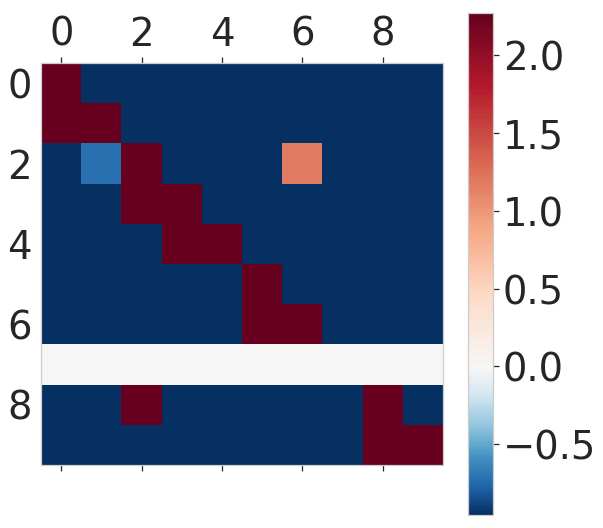

In [25]:
dic = train_network(N, dt, training_time, inter_sequence_time, sequences, tau_z,
                    tau_z_post, tau_w, epochs=epochs, max_w=max_w, min_w=min_w, gh=gh, gah=gah, 
                    pre_rule=False, save_w_history=True)

w = dic['w']


plt.matshow(w, cmap=cmap_show, norm=norm)
plt.colorbar();

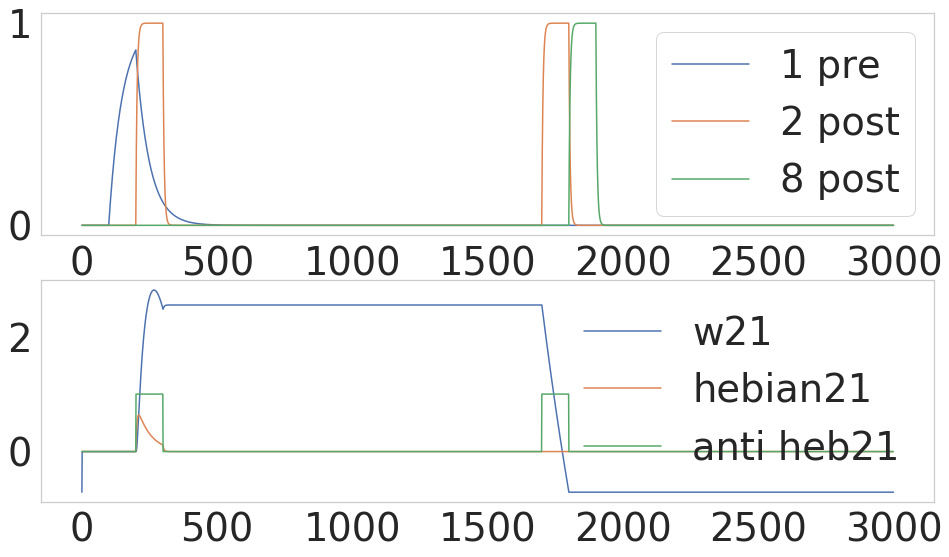

In [26]:
time = np.arange(0, T, dt)
z = dic['z']
z_post = dic['z_post']
w_hist = dic['w_history']
normal = dic['normal']
negative = dic['negative']

fig = plt.figure()
ax = fig.add_subplot(211)

ax.plot(z[:, 1], label='1 pre')
ax.plot(z_post[:, 2], label='2 post')
ax.plot(z_post[:, 8], label='8 post')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(w_hist[:, 2, 1], label='w21')
ax.plot(normal[:, 2, 1], label='hebian21')
ax.plot(negative[:, 2, 1], label='anti heb21')
ax.legend(frameon=False);

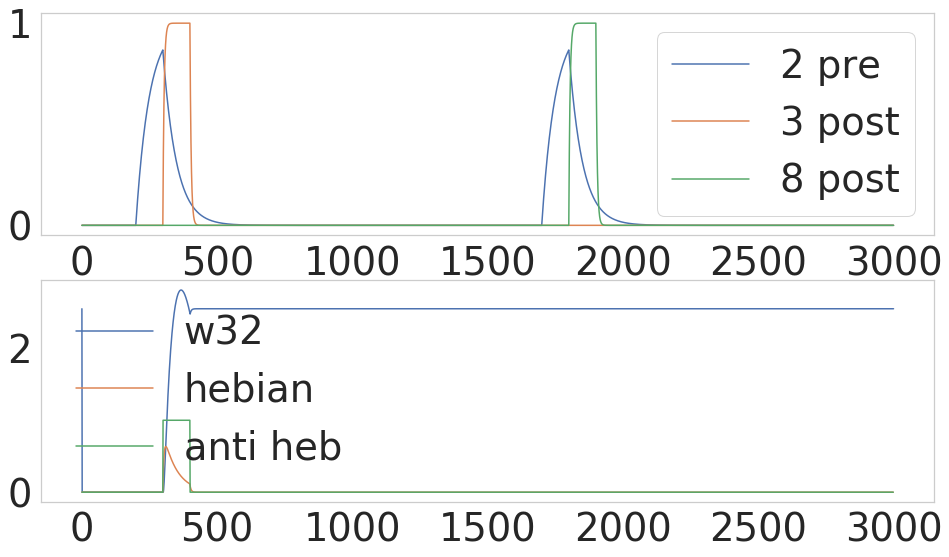

In [27]:
index_from = 1
index_to = 2
time = np.arange(0, T, dt)
z = dic['z']
z_post = dic['z_post']
w_hist = dic['w_history']
normal = dic['normal']
negative = dic['negative']

fig = plt.figure()
ax = fig.add_subplot(211)

ax.plot(z[:, 2], label='2 pre')
ax.plot(z_post[:, 3], label='3 post')
ax.plot(z_post[:, 8], label='8 post')
ax.legend()

ax = fig.add_subplot(212)
ax.plot(w_hist[:, 3, 2], label='w32')
ax.plot(normal[:, 3, 2], label='hebian')
ax.plot(negative[:, 3, 2], label='anti heb')
ax.legend(frameon=False);

In [28]:
index_from = 2
index_to = 8
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

index_from = 2
index_to = 3
exc_t = w[index_to, index_from]
exc_s = w[index_from, index_from]
inh = w[index_from, index_to]
print('exc_t', exc_t, 'exc_s', exc_s, 'inh', inh)

exc_t 2.5501699432874703 exc_s 14.033286408226068 inh -4.426185644798711
exc_t 2.550169943287174 exc_s 14.033286408226068 inh -4.454970519054257


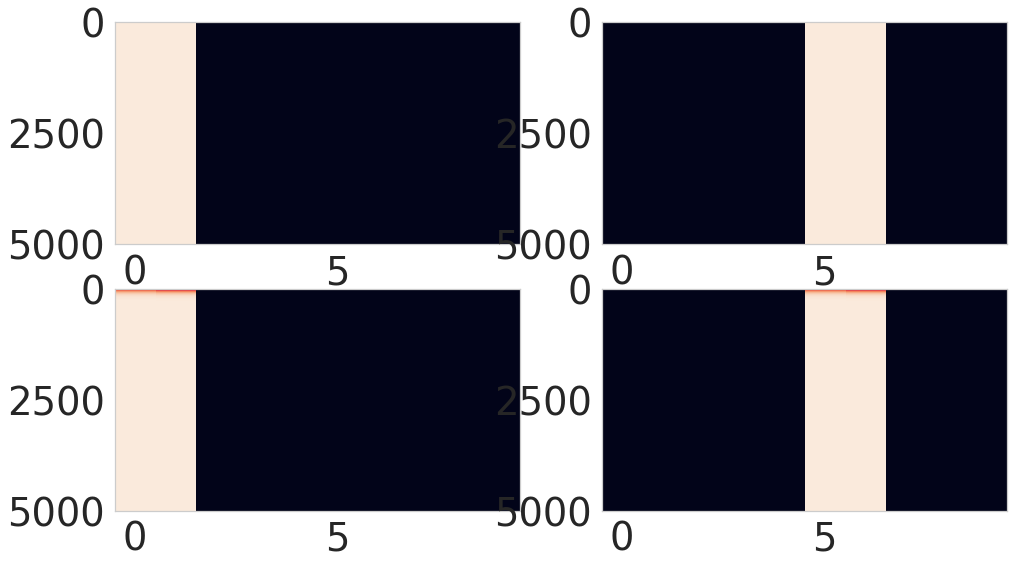

In [29]:
T = 5.0
I_end = 5.0
T_cue = 0.100

I_cue = sequences[0][0]
dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)
x_history_1 = np.copy(dic['x'])
z_history_1 = np.copy(dic['z'])

I_cue = sequences[1][0]
dic = run_network_recall_limit(N, w, G, threshold, tau_z, T, dt, I_cue, T_cue)
x_history_2 = np.copy(dic['x'])
z_history_2 = np.copy(dic['z'])

fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.imshow(x_history_1, aspect='auto')

ax2 = fig.add_subplot(222)
ax2.imshow(x_history_2, aspect='auto')

ax3 = fig.add_subplot(223)
ax3.imshow(z_history_1, aspect='auto')

ax4 = fig.add_subplot(224)
ax4.imshow(z_history_2, aspect='auto');